# EUC Calibration Experiment from David Halpern



For the vertical spacing, what are the ECCOv4r4 vertical layers from the surface to 400 m depth?  At the equator (0°), the vertical profile of the zonal velocity component is: 0.1 m s*-1 towards the west from the sea surface at 0 m to 20 m depth; 0.5 m s*-1 towards the east at 20-170 m depth interval; and 0.1 m s-*1 towards the west at depths greater than 170 m.  What would be the “algorithm” or step-by-step computational method to compute the EUC transport per unit width?

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
from pych.calc import haversine

In [24]:
fig_dir = 'euc_figs'
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

## Part 1: simplified transport

Let’s do a calibration calculation.  Imagine the Equatorial Undercurrent at 140°W.  
- At the equator (0°), the vertical profile of the zonal velocity component is: 
    - 0.1 m s*-1 towards the west from the sea surface at 0 m to 20 m depth; 
    - 0.5 m s*-1 towards the east at 20-170 m depth interval; and 
    - 0.1 m s*-1 towards the west at depths greater than 170 m.  
- The EUC transport per unit width is (150 m) x (0.5 m s*-1) = 75 m*2 s*-1.  
- Let’s assume that the identical velocity profile occurs at all latitudes from 1.5°S to 1.5°N.  
- For now, I’ll assume that 1° latitude between 1.5°S and 1.5°N is equal to 110 km (which is a good approximation for this exercise but not for the final computer program).  

The EUC volume transport = (3°) x (110 km) x (150 m) x (0.5 m s*-1) = 24.75 x 10*6 m*3 s*-1 = 24.75 Sv.

Let this EUC transport (24.75 Sv) be constant at all longitudes from 140°E to 80°W.  Please make a plot of the longitudinal distribution of the EUC transport.


In [3]:
lon_arr = np.concatenate((np.arange(140,180),np.arange(-180,-79)),axis=0)
lon = xr.DataArray(lon_arr,coords={'lon':lon_arr},dims=('lon',))

In [4]:
lat_arr = np.arange(-1,2)
lat = xr.DataArray(lat_arr,coords={'lat':lat_arr},dims=('lat',))

In [5]:
deptharr = np.arange(1,200)-.5
depth = xr.DataArray(deptharr,coords={'depth':deptharr},dims=('depth',))

In [6]:
ds = xr.Dataset({'lon':lon,'lat':lat,'depth':depth})

In [7]:
ds

<xarray.Dataset>
Dimensions:  (depth: 199, lat: 3, lon: 141)
Coordinates:
  * lon      (lon) int64 140 141 142 143 144 145 146 ... -85 -84 -83 -82 -81 -80
  * lat      (lat) int64 -1 0 1
  * depth    (depth) float64 0.5 1.5 2.5 3.5 4.5 ... 195.5 196.5 197.5 198.5
Data variables:
    *empty*

In [8]:
ds['dyG'] = xr.DataArray(np.array([110000,110000,110000]),coords=ds.lat.coords,dims=('lat',))

In [9]:
ds['drF'] = xr.DataArray(np.array([1]*199),coords=ds.depth.coords,dims=('depth',))

In [10]:
ds = ds.set_coords(['dyG','drF'])

In [11]:
ds['uvel'] = xr.zeros_like(ds.depth*ds.lat*ds.lon)

### Create the velocity profile

- At the equator (0°), the vertical profile of the zonal velocity component is: 
    - 0.1 m s*-1 towards the west from the sea surface at 0 m to 20 m depth; 
    - 0.5 m s*-1 towards the east at 20-170 m depth interval; and 
    - 0.1 m s*-1 towards the west at depths greater than 170 m.  
- Let’s assume that the identical velocity profile occurs at all latitudes from 1.5°S to 1.5°N.  

In [12]:
ds['uprof'] = xr.where(ds.depth<20,-0.1,0.) + \
          xr.where((ds.depth>=20) & (ds.depth<170),0.5,0.) + \
          xr.where(ds.depth>=170,-0.1,0.)
ds.uprof.attrs['units'] = 'm/s'

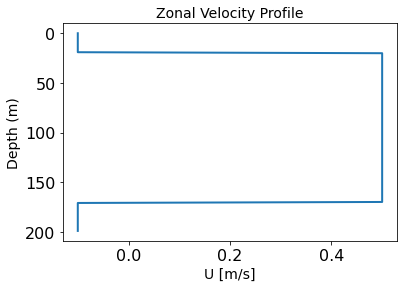

In [25]:
ds.uprof.plot(y='depth',yincrease=False)
plt.xlabel('U [m/s]')
plt.ylabel('Depth (m)')
plt.title('Zonal Velocity Profile')
plt.savefig(f'{fig_dir}/simple_zonal_velocity_profile.png',bbox_inches='tight')

### "Broadcast" this profile to latitudes and longitudes in the domain

Show a plot at two random places as verification

In [26]:
ds['uvel'],_ = xr.broadcast(ds.uprof,ds.lat*ds.lon)
ds.uvel.attrs['units'] = 'm/s'

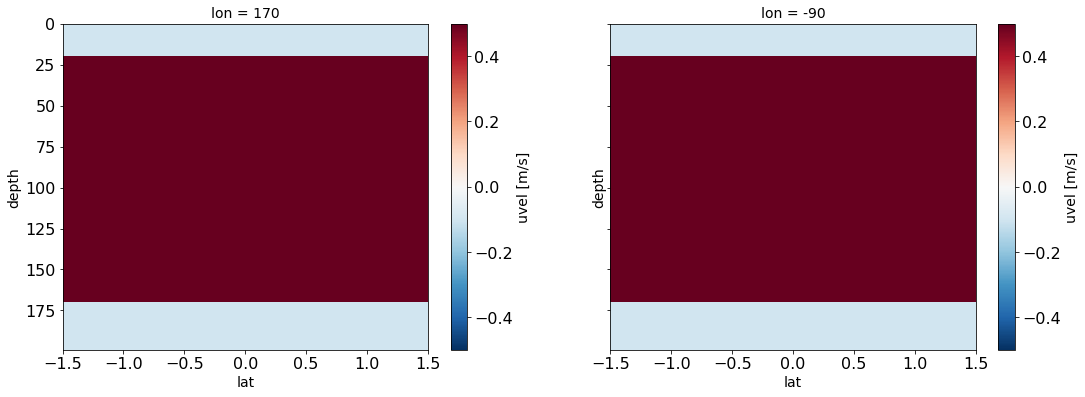

In [27]:
fig,axs = plt.subplots(1,2,figsize=(18,6),sharey=True)
ds.uvel.sel(lon=170).plot(ax=axs[0],yincrease=False)
ds.uvel.sel(lon=-90).plot(ax=axs[1],yincrease=False)

### The EUC transport per unit width is (150 m) x (0.5 m s*-1) = 75 m*2 s*-1.  

Plot below verifies this...

In [28]:
ds['trsp_per_width'] = (ds['uvel']*ds['drF']).where(ds.uvel>0).sum('depth')
ds.trsp_per_width.attrs['units'] = 'm^2/s'

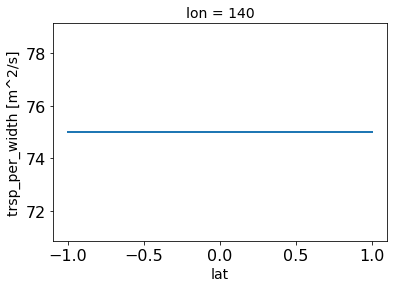

In [29]:
ds.trsp_per_width.sel(lon=140).plot()

In [30]:
ds['trsp'] = ds['uvel']*ds['drF']*ds['dyG']

In [31]:
euc = ds['trsp'].where(ds.uvel>0).sum(['lat','depth']) / 1e6
euc.attrs['units']='Sv'

In [33]:
def euc_plot(xda,xcoord='XG',ax=None,xskip=10):
    
    if ax is None:
        fig,ax = plt.subplots(1,1)
    x=xda[xcoord]
    
    xbds = [140,-80]
    # Grab Pacific
    xda = xda.where((x<=xbds[0])|(x>=xbds[1]),drop=True)
    x_split=xda[xcoord]
    xda[xcoord]=xr.where(xda[xcoord]<=0,360+xda[xcoord],xda[xcoord])
    xda = xda.sortby(xcoord)
    
    xda.plot(ax=ax)
    
    xlbl = [f'{xx}' for xx in np.concatenate([np.arange(xbds[0],181),np.arange(-179,xbds[1])])]
    x_slice = slice(None,None,xskip)
    ax.xaxis.set_ticks(xda[xcoord].values[x_slice])
    ax.xaxis.set_ticklabels(xlbl[x_slice])
    ax.set_xlim([xbds[0],xbds[1]+360])
    
    return ax

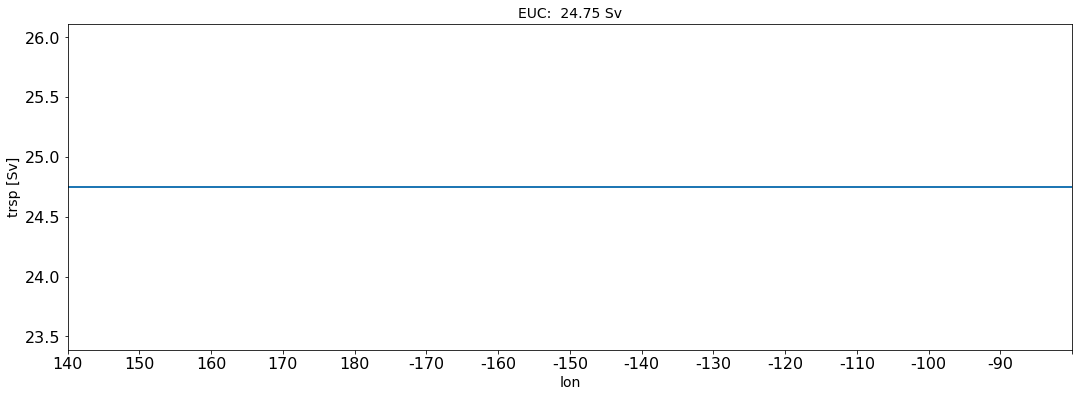

In [34]:
fig,ax = plt.subplots(1,1,figsize=(18,6))
euc_plot(euc,xcoord='lon',ax=ax)
plt.title(f'EUC:  {euc[0].values} {euc.attrs["units"]}')
plt.savefig(f'{fig_dir}/simplified_euc.png',bbox_inches='tight')

## Part 2: The LLC90 grid with telescoping refinement near the equator

The next thought-experiment calculation will provide me with a greater appreciation of the ECCOv4r4 horizontal grid spacing, which, I believe, has a 1° x 1° horizontal grid spacing. 

In the latitudinal direction, where are the grid points? 
For example, are 0° and 1° at grid points or are 0.5° and 1.5° at grid points?  

If 0° is a grid point, then is the ECCOv4r4 value of the zonal current at a specific depth, say 20 m, constant from 0.5°S to 0.5°N?